## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.19833329, 0.17492939, 0.46304818, 0.16368914],
        [0.27173101, 0.07709475, 0.42047745, 0.23069679],
        [0.29028593, 0.12587894, 0.27258057, 0.31125457],
        [0.18261129, 0.29860844, 0.24439426, 0.27438601]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 2)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



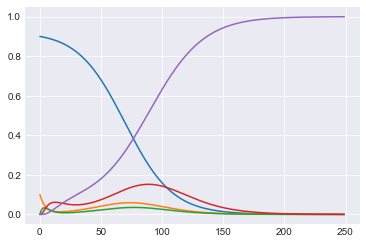

In [6]:
ref_traj = model(R, tmat.value, start, 0.1)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 7, 2)
tmat.add_transition('I', 'R', 4, 4)

In [8]:
param_model = maxentep.ParameterJoint(np.zeros((M,)), R * 0.8, tmat, name='unbiased_model')

In [9]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]

(8192, 250, 4, 4)


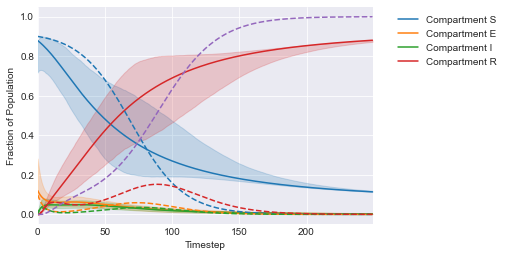

In [10]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [11]:
npoints = 3
#prior = maxentep.Laplace(0.01)
prior = maxentep.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.01)

73 0.3497474 0.3591118155934816
101 0.6428947 0.6446240348755246
66 0.28786126 0.27552647105919537


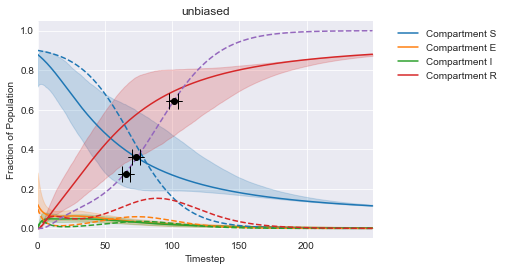

In [12]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [13]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [14]:
history = me_model.fit(trajs, batch_size=8,epochs=8)

Epoch 1/8
1024/1024 [==============================] - 1s 516us/step - loss: 0.0294
Epoch 2/8
1024/1024 [==============================] - 1s 520us/step - loss: 0.0245
Epoch 3/8
1024/1024 [==============================] - 1s 519us/step - loss: 0.0241
Epoch 4/8
1024/1024 [==============================] - 1s 541us/step - loss: 0.0218
Epoch 5/8
1024/1024 [==============================] - 1s 526us/step - loss: 0.0209
Epoch 6/8
1024/1024 [==============================] - 1s 520us/step - loss: 0.0193
Epoch 7/8
1024/1024 [==============================] - 1s 518us/step - loss: 0.0173
Epoch 8/8
1024/1024 [==============================] - 1s 567us/step - loss: 0.0175


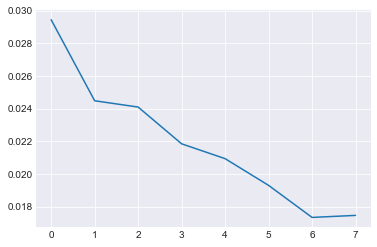

In [15]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [16]:
fit_param_model = maxentep.ParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model')
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [17]:
hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=10, batch_size=16, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 562us/step - loss: 0.0347
Epoch 2/8
32/32 [==============================] - 0s 531us/step - loss: 0.0180
Epoch 3/8
32/32 [==============================] - 0s 594us/step - loss: 0.0185
Epoch 4/8
32/32 [==============================] - 0s 562us/step - loss: 0.0237
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 0.0173
Epoch 6/8
32/32 [==============================] - 0s 562us/step - loss: 0.0184
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0187
Epoch 8/8
32/32 [==============================] - 0s 531us/step - loss: 0.0241
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0480 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.1515e-04 - beta-dist_loss: -0.0527
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0485 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.3044e-0

32/32 [==============================] - 0s 1ms/step - loss: -0.0467 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -1.0271e-04 - beta-dist_loss: -0.0517
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0467 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -9.3768e-05 - beta-dist_loss: -0.0516
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0475 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -1.1006e-04 - beta-dist_loss: -0.0525
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0474 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -9.0334e-05 - beta-dist_loss: -0.0525
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0472 - R-dist-dist_loss: 0.0099 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -9.9601e-05 - beta-dist_loss: -0.0522
Epoch 7/8
32/32 [=======================

32/32 [==============================] - 0s 562us/step - loss: 0.0167
Epoch 5/8
32/32 [==============================] - 0s 563us/step - loss: 0.0143
Epoch 6/8
32/32 [==============================] - 0s 562us/step - loss: 0.0198
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0169
Epoch 8/8
32/32 [==============================] - 0s 563us/step - loss: 0.0143
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0500 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -7.2640e-05 - beta-dist_loss: -0.0548
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0497 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -9.3726e-05 - beta-dist_loss: -0.0545
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0499 - R-dist-dist_loss: 0.0100 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -8.9622e-05 - beta-dist_loss: -0.0546
Epoch 4/8
32/32 [===========

In [18]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.4304435]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [19]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
_______________________________________________________________________________

In [20]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([-0.4582915 , -0.19695084, -0.5048037 , -0.34095728], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [21]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[ 0.03004571 -0.09495961  0.06899403] [ 0.02048195 -0.08263909  0.05494452]
0.0048934165 0.0034225434


In [22]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.640196 after tuning 8.732589


## Direct Regression of Model

In [23]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [24]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 8s 78ms/step - loss: 0.0111 - output_2_loss: 0.0111


## Now visualize results

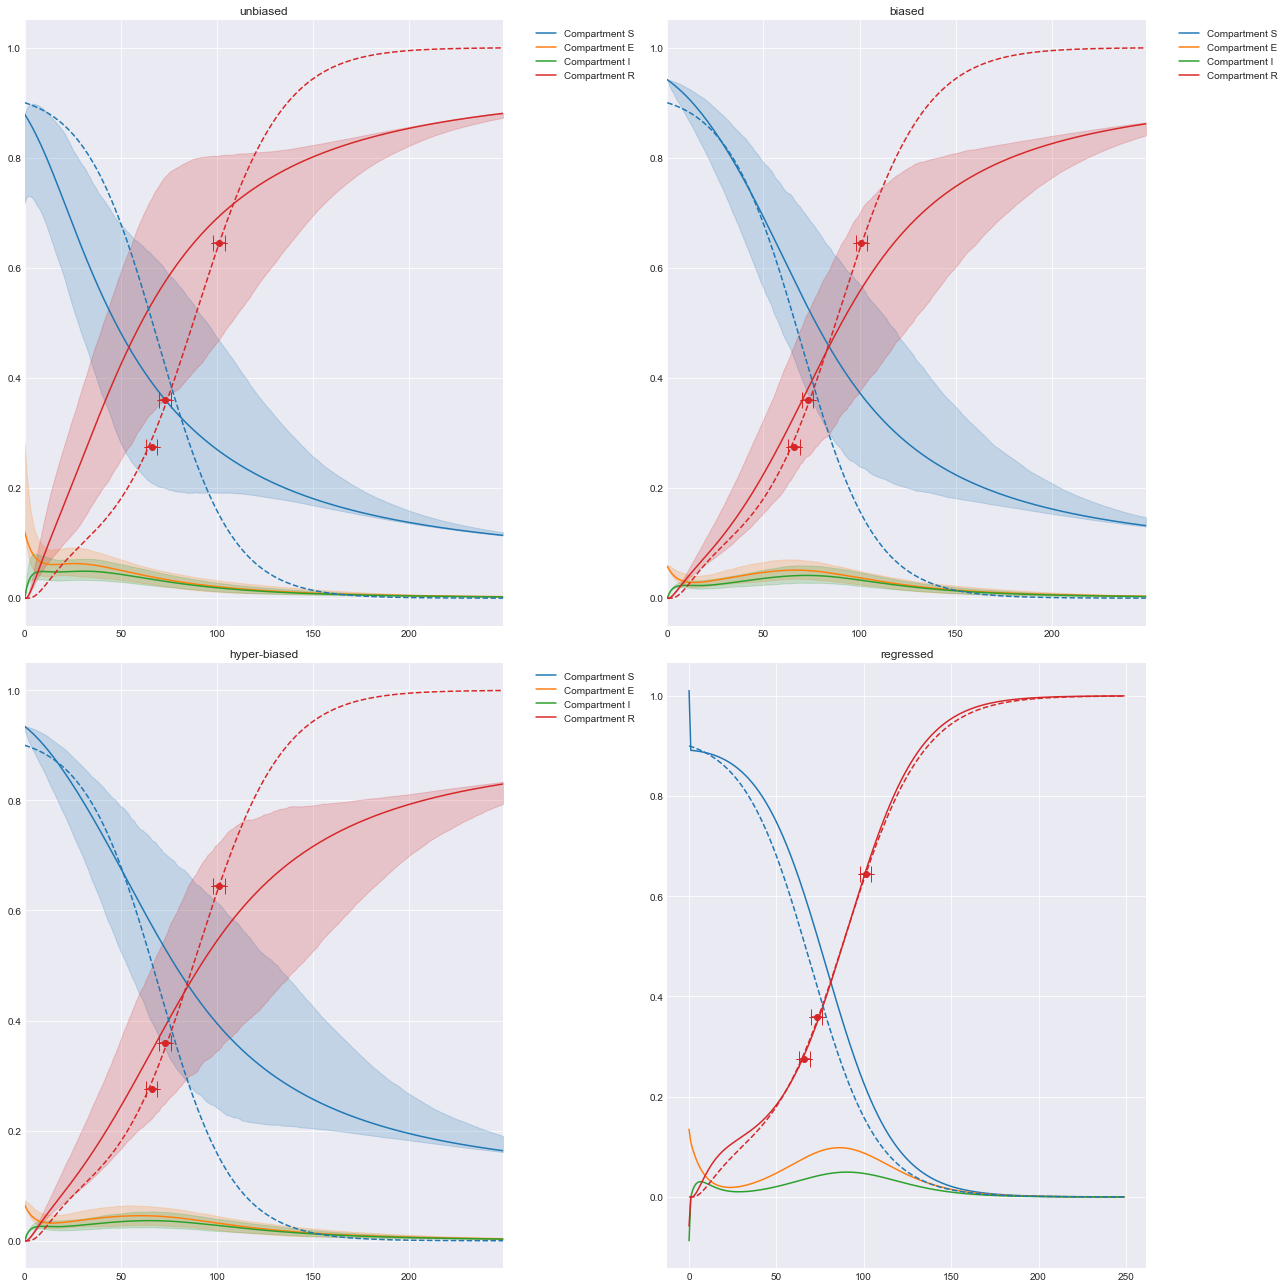

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('traj_match.png', dpi=300)
plt.show()

## Other Patch

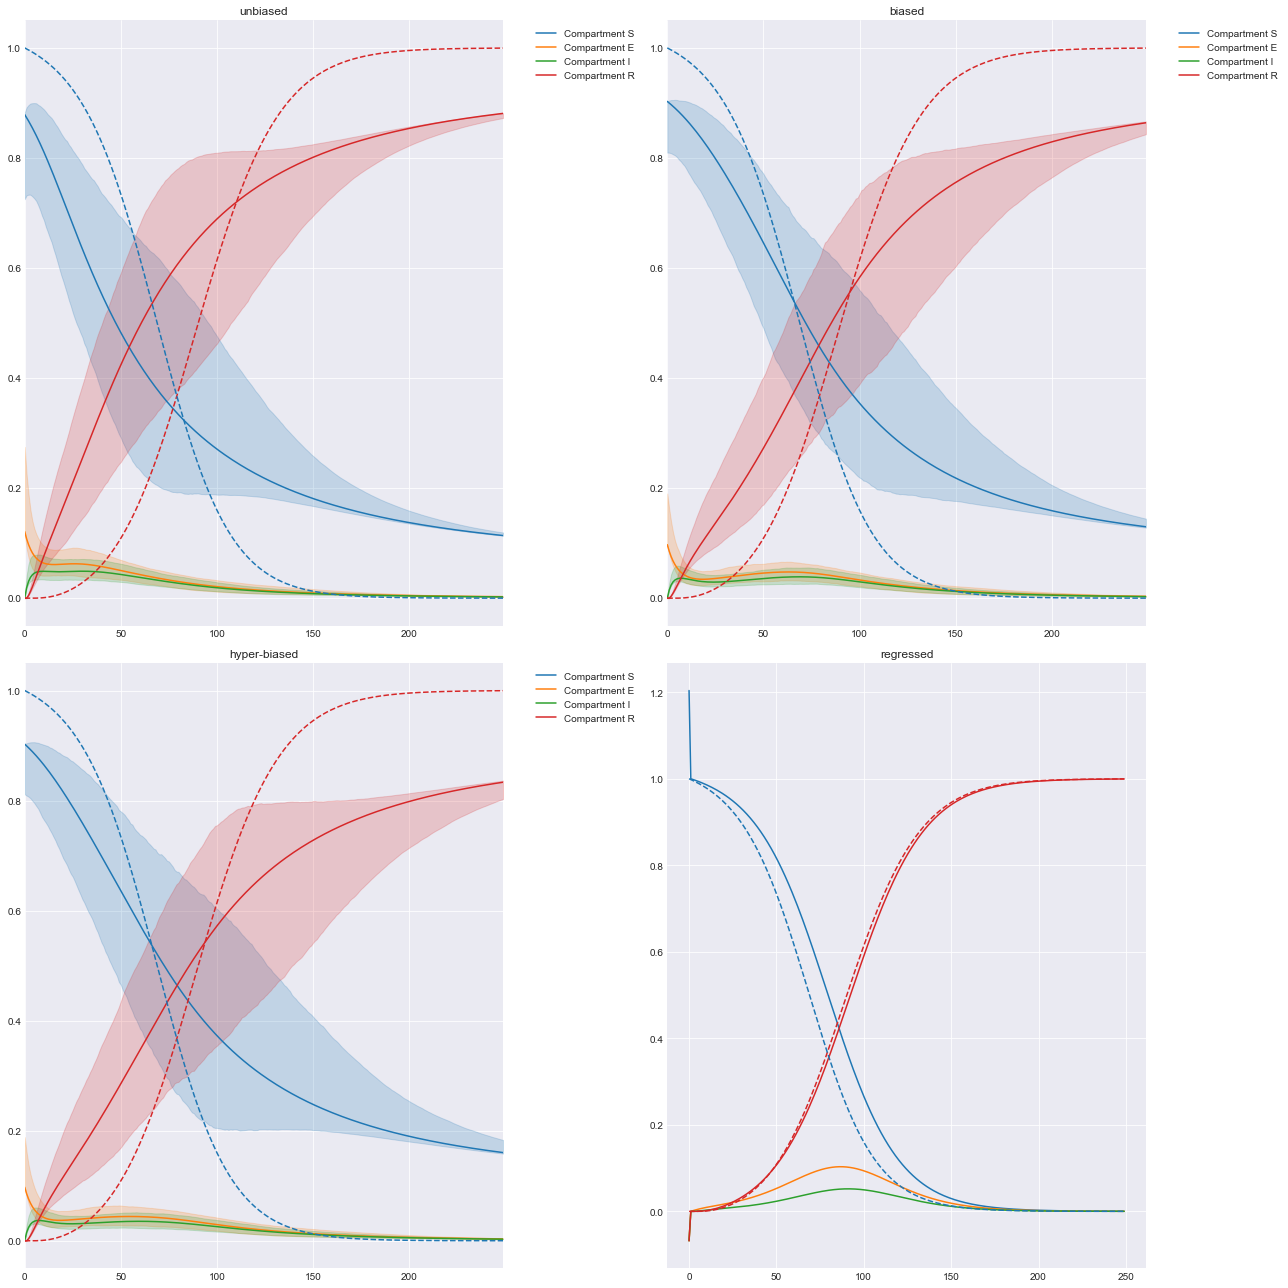

In [26]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()
plt.savefig(f'traj_match_patch_{patch}.png', dpi=300)
plt.show()